In [1]:
import torch
from stable_baselines3 import PPO, SAC
from stable_baselines3.common.env_checker import check_env
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from dynamic_tasker.access import *
from dynamic_tasker.schedulers import *
from dynamic_tasker.orbits import *
from dynamic_tasker.cameras import *
import matplotlib.pyplot as plt
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, SubprocVecEnv
from gymnasium.wrappers import RecordEpisodeStatistics 
import scipy.stats as st
import datetime
%load_ext autoreload
%autoreload 2


In [51]:
class LookaheadEnv(gym.Env):

    def __init__(self, orbit, requests, t_start, t_end, agility, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=False):
        self.orbit = orbit
        self.requests = requests
        self.t_start = t_start
        self.t_end = t_end
        self.agility = agility
        self.field_of_regard = field_of_regard
        self.width = 800
        self.height = 800
        self.K = get_intrinsics_from_fov(45, self.width, self.height)
        self.eval_analytic = eval_analytic
        self.orbit_reset_count = 0
        # Obtain the omniscient schedule
        self.accesses = get_accesses(requests, orbit, 500, 45, t_start, t_end)
        # Assign the states
        for i in range(len(self.accesses)):
            self.accesses[i].state = {"observed": False, "cloudy": np.random.rand() < 0.66}

        # self.optimal_schedule = milp_schedule(self.orbit, self.requests, t_start, t_end)
        self.schedule = milp_schedule(self.accesses, self.requests, self.agility)
        # Calculate how many tasks in the schedule are not cloudy
        self.base_advantage = np.sum([not a.state["cloudy"] for a in self.schedule])
        self.current_idx = 0
        
        # Try first discretizing in just time and angle...
        self.crosstrack_discretization = crosstrack_discretization
        self.alongtrack_discretization = alongtrack_discretization

        # Figure out the number of states
        self.crosstrack_states = int(np.floor(2 * self.field_of_regard / (self.crosstrack_discretization)))
        # First figure out the horizon angle
        self.horizon_angle = horizon_angle(self.orbit)
        self.horizon_time = horizon_time(self.orbit)
        self.alongtrack_states = int(np.floor(self.horizon_time/ (self.alongtrack_discretization)))


        # total_observational_states = crosstrack_states * alongtrack_states

        # Action space - 3d vector, 
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,))
        self.observation_space = spaces.Box(low=0.0, high=np.inf, shape=(2, self.alongtrack_states, self.crosstrack_states))


    def step(self, action):
        # Current time...
        time = self.schedule[self.current_idx].time
        orbit_new = propagate_orbit(self.orbit, time)
        r , v = kepler2eci(orbit_new)
        pos_ecef = eci2ecef(r, time)
        
        # Convert to ECI points
        accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(self.accesses)]
        accesses_filtered = filter_accesses_horizon(orbit_new, time, accesses_converted, pos_ecef)
        points = np.array([r for r, _, _, _, _ in accesses_filtered])

        # Get pitch and roll from action
        pitch_deg = action[0] * (np.rad2deg(self.horizon_angle))
        # roll_deg = np.arcsin(action[2])
        # For now roll_deg = 0
        roll_deg = 0

        # (Optional) Return equivalent analytic DT pairing
        # Calculate analytic heuristic...
        if(self.eval_analytic):
            _, _, utility_analytic, _, _, _, _ = actual_advantage(pitch_deg, roll_deg, orbit_new, self.K, time, accesses_filtered, points, self.schedule)
        # If the first action is 0, don't do anything
        if pitch_deg <= 22.5 or len(accesses_filtered) == 0:                
            self.current_idx = self.current_idx + 1
            return self._get_obs(accesses_filtered, self.schedule,time), 0, False, True, {"utility_analytic": None if not self.eval_analytic else utility_analytic}


        # 22.5 deg boresight        
        t_maneuver = (self.agility(pitch_deg - 22.5) * 2) - 2 * self.agility(0)
        
        # Now project them into the camera frame
        projected_accesses, in_box, projected_points = project_in_box(pitch_deg, roll_deg, orbit_new, time, accesses_filtered, points, self.width, self.height, self.K)
        # Mark the ones in box as observed
        for i in in_box:
            accesses_filtered[i][-2].state["observed"] = True

        # Calculate the total advantage
        times = [a[-2].time for a in projected_accesses]

        if(len(times) == 0):
            self.current_idx = self.current_idx + 1
            
            missed_opportunities = len([s for s in self.schedule if s.time >= time and s.time <= time + datetime.timedelta(seconds=t_maneuver)])
            return self._get_obs(accesses_filtered, self.schedule,time), 0, False, True, {"utility_analytic": None if not self.eval_analytic else utility_analytic}

        max_time = np.max(times)
        min_time = np.min(times)

        # Get the slice of the schedule that is in the time range
        schedule_slice = [a for a in self.schedule if a.time >= min_time and a.time <= max_time]
        original_schedule_advantage = np.sum([not a.state["cloudy"] for a in schedule_slice])
        access_slice = [a for a in self.accesses if a.time >= min_time and a.time <= max_time and not (a.state["observed"] and a.state["cloudy"])]
        access_slice_omni = [a for a in self.accesses if a.time >= min_time and a.time<= max_time and not (a.state["cloudy"])]

        new_schedule = milp_schedule(access_slice, self.requests, self.agility)
        omni_schedule = milp_schedule(access_slice_omni, self.requests, self.agility)

        new_advantage = np.sum([not a.state["cloudy"] for a in new_schedule])
        omni_advantage = len(omni_schedule)

        
        missed_opportunities = len([s for s in schedule_slice if not s.state["cloudy"] and self.agility(s.angle) > t_maneuver])
        # reward = new_advantage - missed_opportunities - original_schedule_advantage# - 0.01 * (t_maneuver)
        if(omni_advantage == missed_opportunities):
            reward = 0
        else:
            reward = (new_advantage - missed_opportunities) / (omni_advantage - missed_opportunities)


        # Move to the next schedule block
        self.current_idx = self.current_idx + 1
        
        return self._get_obs(accesses_filtered, self.schedule, time), reward, False, True, {"utility_analytic": None if not self.eval_analytic else utility_analytic}
    
    def reset(self, seed=None, options=None):
        # Only actually reset when current_idx is at the end
        if self.current_idx >= (len(self.schedule) - 1):
            self.orbit_reset_count = self.orbit_reset_count + 1

            if(self.orbit_reset_count > 10):
                self.requests = generate_requests(10000)
                self.accesses = get_accesses(self.requests, self.orbit, 500, 45, self.t_start, self.t_end)
                self.orbit_reset_count = 0

            self.current_idx = 0
            for a in self.accesses:
                a.state = {
                    "observed": False,
                    "cloudy": np.random.rand() < 0.66
                }
                
            self.schedule = milp_schedule(self.accesses, self.requests, self.agility)
            
        r , v = kepler2eci(self.orbit)
        pos_ecef = eci2ecef(r, self.t_start)    
        accesses_converted = [(latlong2ecef([a.lat, a.long]), a.angle, a.time, a, i) for i, a in enumerate(self.accesses)]
        accesses_filtered = filter_accesses_horizon(self.orbit, self.t_start, accesses_converted, pos_ecef, self.field_of_regard)

        return self._get_obs(accesses_filtered, self.schedule, self.t_start), {}

    def _get_obs(self, accesses, schedule, time):
        # Source data
        times = [(a[2] - time).total_seconds() for a in accesses if not a[-2].state["observed"]]
        angles = [a[1] for a in accesses if not a[-2].state["observed"]]

        schedule_times = [(a.time - time).total_seconds() for a in schedule]
        schedule_angles = [a.angle for a in schedule]

        # Convert to 2D histogram
        hist_accesses = np.histogram2d(times, angles, bins=[self.alongtrack_states, self.crosstrack_states], range=[[0, self.horizon_time], [-self.field_of_regard, self.field_of_regard]])
        hist_schedule = np.histogram2d(schedule_times, schedule_angles, bins=[self.alongtrack_states, self.crosstrack_states], range=[[0, self.horizon_time], [-self.field_of_regard, self.field_of_regard]])

        return np.stack([hist_accesses[0].astype(np.float32), hist_schedule[0].astype(np.float32)])

    def _get_reward(self):
        pass

    def close(self):    
        pass

In [52]:
# Generate randomly spaced requests

def generate_requests(N):
    """
    Generate N Request objects with lat/long
    sampled uniformly over Earth's surface, using numpy.
    """
    # 1) sample z = sin(lat) uniformly in [-1,1]
    z = np.random.uniform(-1.0, 1.0, size=N)
    # 2) sample longitude angle θ uniformly in [0, 2π)
    theta = np.random.uniform(0.0, 2*np.pi, size=N)

    # convert to lat, lon in degrees
    lat = np.degrees(np.arcsin(z))
    lon = np.degrees(theta)
    # shift to [–180, +180)
    lon = np.where(lon > 180.0, lon - 360.0, lon)

    # build Request instances
    return [
        Request(i, float(lat[i]), float(lon[i]), f"request_{i}")
        for i in range(N)
    ]

# requests = generate_requests(10)
# print(requests)

In [53]:
# Train with PPO
t0 = datetime.datetime(2024, 1, 1)
t_end = datetime.datetime(2024, 1, 1, 18, 0, 0)

h = 400
field_of_regard = 45
crosstrack_discretization = 5 # deg
alongtrack_discretization = 5 # seconds

t_s = 10
t_dotsq = 4
def agility_bangbang(theta):
    return t_s + t_dotsq * np.sqrt(np.abs(theta))

orbit = circular_orbit(a=Constants.R_E+h, i=np.deg2rad(51.6), Omega=np.pi, M=np.pi/2, t=t0)
requests = generate_requests(10000)

# env.reset()
# env.step(np.array([1, 0, 0]))
# env = LookaheadEnv(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization)

# check_env(env)

In [54]:
# Some helpers for the analytic one
width = 800
height = 600

def analytic_chain_probability(L, lam, M, c):
    if L < (M-1)*c:
        return 0.0
    x = L - (M-1)*c
    # Note: scipy's gamma.cdf(x, a, scale) uses 'a' as the shape and scale=1/rate.
    return st.gamma.cdf(x, a=M-1, scale=1/lam)

def expected_advantage(N, t_total, t_gap, A_min, A_max):
   all_adv = np.arange(A_min, A_max+1)

   probabilities = np.array([analytic_chain_probability(t_total, N/t_total * 1/3, adv + 2, t_gap) for adv in all_adv])
   probabilities = [probabilities[i] - probabilities[i+1] for i in range(len(probabilities)-1)]
   probabilities = np.append(probabilities, probabilities[-1])
   
   return np.sum(probabilities * all_adv)

def actual_advantage(pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule):
    accesses_inbox, in_box_idx, projected_points = project_in_box(pitch_deg, roll_deg, orbit, time, accesses_filtered, points, width, height, K)
    N = len([a for a in accesses_inbox if a[-2].state["observed"] == False]) * 0.34
    adv = 0
    if(N > 0):
        t_total = np.max([a[2] for a in accesses_inbox]) - np.min([a[2] for a in accesses_inbox])
        t_gap = agility_bangbang(30)

        if(t_total.total_seconds() > 0):
            adv = expected_advantage(N, t_total.total_seconds(), t_gap, 2, 40)

    # Now calculate cost...
    # Check how many tasks in the schedul we miss
    schedule_filtered = [s for s in schedule if s.time > time and s.time <= time + datetime.timedelta(hours=1)]
    # Total lookahead maneuver time
    # No setting time for lookahead
    # Assume 35 deg boresight angle
    t_maneuver = 2 * (agility_bangbang(pitch_deg - 35)) - agility_bangbang(0)

    schedule_missed = [s for s in schedule_filtered if time + datetime.timedelta(seconds=t_maneuver) > s.time]

    cost = len(schedule_missed) * 0.34
    utility = adv - cost
    missed = len(schedule_missed)
    return accesses_inbox, in_box_idx, utility, adv, cost, missed, t_maneuver

def evaluate_lookahead_chain(time, orbit, schedule, accesses, K):
    orbit_new = propagate_orbit(orbit, time)
    r , v = kepler2eci(orbit_new)
    pos_ecef = eci2ecef(r, time)
    v_ecef = eci2ecef(v, time)

    accesses_filtered = filter_accesses_horizon(orbit, time, accesses, pos_ecef)
    min_time = agility_bangbang(30)
    accesses_filtered = [a for a in accesses_filtered if a[-2].time > time + datetime.timedelta(seconds=min_time)]
    # Let's do a test to figure out what the heuristic will do best at...
    points = np.array([r for r, _, _, _, _ in accesses_filtered])
    idxs = np.array([i for _, _, _, _, i in accesses_filtered])

    roll_deg = 0
    pitch_degs = np.linspace(0, 70)

    expected_utilities = []
    expected_advantages = []
    expected_costs = []
    for pitch_deg in pitch_degs:
        _, _, utility, adv, cost, _, _ = actual_advantage(pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule)
        
        expected_utilities.append(utility)
        expected_advantages.append(adv)
        expected_costs.append(cost)

    # Find the maximum advantage
    max_adv = np.max(expected_utilities)
    max_idx = np.argmax(expected_utilities)
    # Find the pitch angle that gives the maximum advantage
    best_pitch_deg = pitch_degs[max_idx]

    # Recalculate in box
    accesses_inbox, in_box_idx, utility, adv, cost, missed, t_maneuver = actual_advantage(best_pitch_deg, roll_deg, orbit, K, time, accesses_filtered, points, schedule)

    mapped_in_box_idx = [idxs[i] for i in in_box_idx]
    # Recalculate utility
    return ((best_pitch_deg, roll_deg), mapped_in_box_idx, expected_utilities, expected_advantages, expected_costs, utility, adv, cost, missed, t_maneuver)

In [55]:
# Now train with PPO
# env = LookaheadEnv(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=False)
# env = RecordEpisodeStatistics(env)
# env = DummyVecEnv([lambda: env])
# env = VecNormalize(env, norm_obs=False, norm_reward=True)
# train_env = env

def make_env(rank, seed=0):
    def _init():
        env = LookaheadEnv(
            orbit, requests, t0, t_end,
            agility_bangbang, field_of_regard,
            crosstrack_discretization, alongtrack_discretization,
            eval_analytic=False,
        )
        env = RecordEpisodeStatistics(env)
        env.reset(seed=seed + rank)
        return env
    return _init

N_ENVS = 8                                # ≤ number of CPU cores
train_env = SubprocVecEnv([make_env(i) for i in range(N_ENVS)])

train_env = VecNormalize(
    train_env,
    norm_obs=False,
    norm_reward=True,
)


/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: overflow encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: invalid value encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: overflow encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: invalid value encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: Runt

In [56]:
# model = PPO("MlpPolicy", env, verbose=1, tensorboard_log="./test_with_schedule")

# Define a larger policy network with 5 layers
policy_kwargs = {
    "net_arch": {
        "pi": [256, 256, 256, 256, 256],  # Policy network: 5 layers of 256 units
        "qf": [256, 256, 256, 256, 256]   # Q-function network: 5 layers of 256 units
    }
}

model = SAC("MlpPolicy", train_env, verbose=0, tensorboard_log="./test_with_schedule", policy_kwargs=policy_kwargs, gamma=1.0, device="mps")
# model = PPO("MlpPolicy", train_env, verbose=0, tensorboard_log="./test_with_schedule", policy_kwargs=policy_kwargs, gamma=1.0)
model.learn(total_timesteps=500000)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:242: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 23.92GB > 10.20GB
  warnings.warn(


KeyboardInterrupt: 

In [57]:
model.save("test_with_schedule_sac_debugged_horizonfixed_250k")

In [12]:
# Eval environment

# eval_env = LookaheadEnv(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=True)

In [50]:
N = 500

eval_env = LookaheadEnv(orbit, requests, t0, t_end, agility_bangbang, field_of_regard, crosstrack_discretization, alongtrack_discretization, eval_analytic=True)
analytic_rl_pairs = []
state = eval_env.reset()[0]
for i in tqdm(range(N)):
    action, _ = model.predict(state)
    print(action[0] * (np.rad2deg(eval_env.horizon_angle) - 22.5))
    # pitch_deg = np.rad2deg(np.arcsin(action[1]))
    # roll_deg = np.rad2deg(np.arcsin(action[1]))
    # print(roll_deg)
    state, reward, done, truncated, info = eval_env.step(action)
    eval_env.reset()
    analytic_rl_pairs.append((info["utility_analytic"], reward))

    if done:
        state = eval_env.reset()

print(analytic_rl_pairs)

/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: divide by zero encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: overflow encountered in matmul
  eci = ecef @ rot_mat.T
/Users/shreeyam/phd_code/src/dynamic_tasker/orbits.py:61: RuntimeWarning: invalid value encountered in matmul
  eci = ecef @ rot_mat.T
  1%|          | 6/500 [00:00<00:25, 19.45it/s]

43.35874515469127
47.53946637713255
44.73463746269397
45.34293184309631
45.61449020909117
45.59793697494205
45.55632635370465
45.928484013832595
45.3629265571974


  3%|▎         | 15/500 [00:00<00:15, 31.44it/s]

44.500662333133214
46.10296420319895
47.36569723734305
44.992361648121594
47.52787342483155
45.44300211634421
43.9270387300982
43.9521416243594
45.9915512671011


  5%|▌         | 25/500 [00:00<00:12, 36.91it/s]

45.675515327974956
46.23994648208042
46.36753721815082
45.68789896740542
39.48770024396077
45.807065188089275
44.622246122378364
44.517187125299266
41.693501176082556


  7%|▋         | 34/500 [00:01<00:12, 37.75it/s]

25.783869285148334
46.618901776163085
26.70399019118185
46.036819527361835
45.250853767092224
38.2655880500431
47.52244669446101
47.596338966487515


  9%|▊         | 43/500 [00:01<00:11, 39.34it/s]

47.51935220670255
27.973691511179094
46.737499157185454
46.61476062342749
43.19999907036151
37.847667239148926
46.269543209667326
46.18553696845967
24.210157296468676


 10%|▉         | 48/500 [00:01<00:11, 39.99it/s]

45.28548472568325
44.19308503977331
46.86296812131853
43.941043562563884
41.68041217547185
45.25589368649295
45.81639415853758
42.499137411846206
40.79846041072378


 12%|█▏        | 58/500 [00:01<00:10, 40.20it/s]

42.52711294639789
47.45176267812526
45.415237052467276
46.87299107615384
46.8392361306415
45.12259180022127
47.11592543038294
46.5874335660899
45.10135701565815


 13%|█▎        | 63/500 [00:01<00:13, 31.46it/s]

46.85515795276638
47.48898754557264
46.45276077623405
42.57157345433932


 14%|█▍        | 71/500 [00:02<00:12, 34.30it/s]

47.223020873450146
45.04434790478443
46.44972886083835
44.756617427213634
45.34569640385111
46.06615458870446
37.383232409135374
45.58437583741232


 16%|█▌        | 80/500 [00:02<00:11, 37.32it/s]

35.42532042469419
45.64457045039034
46.5428308482331
45.882561587961156
47.01327831346852
46.843525181689074
42.878980095800785
45.33611145555514
40.51342054475179


 18%|█▊        | 88/500 [00:02<00:11, 36.74it/s]

47.42000435982473
46.989091251062305
46.63063124998284
35.694063034364724
47.393866177379635
45.71122708192279
46.142726095536545
46.0485148708019


 19%|█▉        | 96/500 [00:02<00:11, 36.72it/s]

47.11262616034634
46.027046861977574
41.86324861946538
44.643799457151914
47.30849472098442
46.70840300850065
46.296733745486165
34.17143284728614


 21%|██        | 105/500 [00:02<00:10, 37.90it/s]

31.015026891672026
42.877393033145246
42.149073484170216
44.426354808153825
39.023743239262856
46.01710923309148
46.86558478376134
47.153940984959775


 23%|██▎       | 113/500 [00:03<00:10, 38.05it/s]

44.79148161006586
38.58907010033804
47.33922343949767
43.98926978906432
47.21208777515646
46.249463169617016
46.339328459337935
43.12608973314516
46.581984082132905


 24%|██▍       | 121/500 [00:03<00:09, 38.75it/s]

47.53740717755799
46.58978287389182
43.73111897389059
46.74566200632772
47.48969290675288
46.80235256699101
46.073248019283135
43.49072733294832
38.397587293489984


 26%|██▌       | 131/500 [00:03<00:09, 39.69it/s]

47.12177879049958
44.5732405855417
44.82829691295697
38.41266154451926
46.7952875783954
46.71795951481355
44.82400217351278
36.63116949269009
47.38110141537598


 28%|██▊       | 141/500 [00:03<00:08, 40.45it/s]

47.34710755720582
46.43645214313936
47.41543657734303
44.94642784545693
40.53640735547227
44.23266490341922
47.63673227084935
43.049774204160734
45.5629874661406


 30%|███       | 150/500 [00:04<00:09, 38.55it/s]

44.766543679306494
40.25124234477476
42.429710531162335
47.424026056231405
47.29770952100272
47.482337809929916
47.15881025246206
43.177114650780084


 32%|███▏      | 158/500 [00:04<00:08, 38.38it/s]

47.02234561767254
47.48930609578307
45.38441163121157
45.590963000692284
47.513373701860374
45.528481652275104
45.35205034286986
39.603368100726506


 33%|███▎      | 167/500 [00:04<00:08, 38.75it/s]

47.377421022766185
47.60782952764945
47.223214278935046
44.55055525984179
47.478759808459195
43.48002177051922
39.67686218498997
47.183156589973485


 34%|███▍      | 171/500 [00:04<00:08, 39.06it/s]

47.27019474657684
46.87111390527095
47.19411244185363
38.70664925836636
47.283312189170616
46.17105431067834
44.982327316493055


 36%|███▌      | 179/500 [00:04<00:09, 35.26it/s]

47.565416842489356
46.06925476485954
47.499044630787644
45.89140135630059
46.92410131973799
47.376664466016415
47.418502623118414
47.48534128334254
43.02574641685974


 38%|███▊      | 188/500 [00:05<00:08, 37.38it/s]

47.072255609570966
44.52053190250878
43.46267784924064
47.589911078312774
47.1597090191272
45.469020842460395
46.777955033910054
41.51608577406295
47.377910224875066


 39%|███▉      | 197/500 [00:05<00:07, 38.96it/s]

45.090526308503534
42.63142676352045
41.281217566233664
44.51566263500649
42.161934948916326
46.63105219133234
47.05082173112633
46.76036082318041
42.49399510130641


 41%|████▏     | 207/500 [00:05<00:07, 40.12it/s]

44.11596175846959
42.205593392935064
44.8985144807703
46.12254366434716
44.50220388861583
43.58317515473236
45.399514324223915
37.37173047118021
42.30758634423878


 43%|████▎     | 217/500 [00:05<00:06, 40.84it/s]

46.09189458338651
45.89124208119537
45.750812633965324
44.749717402119856
46.16127026850086
39.191255142776065
45.58418243192742
46.78155578896723
44.170086852259594


 45%|████▌     | 227/500 [00:06<00:06, 41.16it/s]

46.357696292007184
45.64583327443883
46.60320748990279
44.3648518639544
45.170522230097745
46.87919142846399
40.507447728306225
44.83173270451232
42.22545727391401


 46%|████▋     | 232/500 [00:06<00:06, 39.89it/s]

37.05236113163778
46.06559143743959
47.47891908356441
44.29562976554866
39.59361250053209
26.172597244615254
47.135362681615774
45.55570631847363
45.52588774341874


 48%|████▊     | 242/500 [00:06<00:06, 40.21it/s]

41.82137633198369
44.614071896442866
47.37344483353243
44.72884098654347
36.6632634263909
45.94954814649727
47.10985591119493
46.43162838281
47.1706876245938


 50%|█████     | 252/500 [00:06<00:06, 40.07it/s]

46.58411723086346
43.44813261909655
44.38533009176775
46.9549267409937
41.73446900850249
38.10796826824307
44.12791876815393
45.62904112763188
46.76483190291966


 52%|█████▏    | 261/500 [00:06<00:06, 39.34it/s]

44.914641085173315
45.38370058163472
45.148286287730414
36.58409232230584
47.41415099970808
43.71933261610468
45.976363248139535
47.194544759996354


 54%|█████▍    | 270/500 [00:07<00:05, 40.02it/s]

46.66479576005145
45.687466649262696
45.52047238984144
47.400373703106986
42.364805925787245
44.97610421059644
46.73149789875682
42.46516630726251
46.30894104462157


 56%|█████▌    | 279/500 [00:07<00:05, 39.43it/s]

44.80110637713813
47.287595551821575
46.156412377791796
46.25646558584986
23.42816203703621
45.90271557716746
46.657275699726654
46.325949350499876
47.132108918752095


 58%|█████▊    | 288/500 [00:07<00:05, 39.37it/s]

46.64488637189958
47.214442771354996
46.57014084038085
47.39399132210516
44.36019875552348
30.169003039943153
46.42378977227477
47.5845867390813


 59%|█████▉    | 297/500 [00:07<00:05, 39.62it/s]

43.45742177076855
46.1697687330434
45.20994281863844
41.98341599795344
47.341453290970684
46.62576767087717
47.169618206030215
47.14594309931934
45.43622723597596


 61%|██████    | 305/500 [00:08<00:05, 38.79it/s]

43.30035945183676
47.40428731997798
46.70184997560038
45.81359546740309
46.69731063510176
46.6747959613003
46.34197925216044
44.05571026152542


 62%|██████▏   | 309/500 [00:08<00:04, 38.59it/s]

42.98994364856606
44.90112545481651
44.85209147599676
41.74186961249836
45.39953138941376
44.79592993621865


 63%|██████▎   | 317/500 [00:08<00:05, 34.40it/s]

43.311690737893485
38.42018160484405
44.38164401076134
43.876116203602336
47.382307355458316
45.41572625457615
44.78712429825891
42.02388893986789


 65%|██████▌   | 326/500 [00:08<00:04, 37.31it/s]

45.537298667028075
45.06280675179952
46.13306719808458
46.458210260191045
45.870450991568205
46.038082351410324
47.46287211671401
43.5534020868504
46.77653293475635


 67%|██████▋   | 334/500 [00:08<00:04, 37.57it/s]

46.92235498197724
45.978138027883354
47.55298200748936
32.871526141264205
44.06470930497006
47.4980662265699
25.848517912675756
38.712178379875965


 68%|██████▊   | 342/500 [00:09<00:04, 36.61it/s]

41.24300860617192
43.51418628058783
45.358785404461806
45.540785654152955
43.93856911003644
45.645941353974514
44.71309550471365
37.9350580763424


 70%|███████   | 350/500 [00:09<00:04, 36.71it/s]

47.39235306388009
45.48214397345078
47.344877705732806
46.72417693231355
42.55243768812707
46.65686613517039
40.64834362405869
45.82315197371598


 72%|███████▏  | 359/500 [00:09<00:03, 38.58it/s]

46.3520989097382
38.44779308201238
46.07314562814407
46.61095508609218
41.11062255175523
47.00299369238893
46.95898825617668
44.85539643442997
46.56373570579256


 74%|███████▎  | 368/500 [00:09<00:03, 39.56it/s]

47.17374229357596
40.805479892146465
39.15943425211276
45.332743924759164
45.32468915515258
30.79403268318629
32.09147062507739
43.26701407088069
43.84981305765541


 75%|███████▌  | 377/500 [00:10<00:03, 39.53it/s]

44.93816829357221
47.21460204646021
45.98868431520723
46.536886473770615
42.10970977959567
44.96646806673094
47.352375012471136
47.23834541393047
43.338528593122206


 77%|███████▋  | 387/500 [00:10<00:02, 40.59it/s]

44.14609319533828
46.7613164738117
45.48798026837759
46.944676250293796
47.10672729305677
46.83498120997361
47.31730035894416
42.71356152224183
46.31047691170757


 79%|███████▉  | 397/500 [00:10<00:02, 40.53it/s]

30.86250391323887
46.839600188024846
46.871284557169396
46.262751264109234
46.167015549081825
46.29043100203695
46.811459689971336
47.360714201908465
43.18320692355456


 80%|████████  | 402/500 [00:10<00:02, 40.46it/s]

45.881640067709554
43.1620347113542
42.45950635263076
44.525674213048575
46.99418805442919
45.763116635843176
45.677176339786485
44.05685931764161
45.55996692753813


 82%|████████▏ | 412/500 [00:10<00:02, 40.87it/s]

46.25025954514309
46.58970323633921
47.35579942723326
44.177510209841934
46.161804977782644
47.44176247687641
47.04629945581755
47.10204005424616
46.97831173947722


 84%|████████▍ | 422/500 [00:11<00:01, 41.32it/s]

45.83299858825624
29.886676539156433
43.389530757170675
44.94918671781512
45.741642938622235
46.295226320383236
47.28813026110337
45.2235153329614


 86%|████████▌ | 431/500 [00:11<00:01, 36.18it/s]

45.175670229034154
39.103488871406014
47.01804518983174
39.38169128464699
47.5092382375214
43.4045481242338
46.288639157103276
45.25773672699616


 88%|████████▊ | 440/500 [00:11<00:01, 38.22it/s]

47.04375674253072
45.09148764753144
45.46884450216533
47.14729693771367
37.24336042477358
46.527876053532744
45.83791336293144
47.110043628283215
46.56917381295633


 90%|████████▉ | 448/500 [00:11<00:01, 38.23it/s]

44.097252622003445
44.511936735223784
42.546049618728624
46.62149568501944
45.933091615090596
47.55619595157673
47.404219059218605
47.0686207241341


 91%|█████████ | 456/500 [00:12<00:01, 38.36it/s]

46.290339987691105
47.332613522631256
47.5782896840287
46.89670031324441
47.41611349654019
47.01930801388023
44.89040282719757
46.19198761022088
47.11557843818943


 93%|█████████▎| 465/500 [00:12<00:00, 38.77it/s]

43.54633709825479
46.988101470051326
45.26688366875278
37.45697678284989
40.75253798485234
47.1730653743788
40.792425021915456
32.36298917229596


 95%|█████████▍| 473/500 [00:12<00:00, 38.74it/s]

46.800577787247185
43.02686134259624
45.84161650912769
39.31385146661865
46.968920196666154
45.52624042400886
46.94415291780523
45.15053889278988
46.33183684099622


 96%|█████████▋| 482/500 [00:12<00:00, 39.21it/s]

46.816334645870235
40.947513467221896
46.03278076576531
38.90130050212887
45.34520151334562
43.645997806946426
8.654229907043934
39.58209349738708
43.732461435491686


 98%|█████████▊| 491/500 [00:12<00:00, 39.50it/s]

47.075065677498685
45.08269338636493
45.5037996993634
47.101630489689896
45.46026071167357
46.15120749488924
45.19612001486443
47.32607186652422
40.17869253434935


100%|██████████| 500/500 [00:13<00:00, 37.98it/s]

46.892752565993725
45.208059959358934
46.76565672042881
46.143590731821995
47.24601906096386
47.39095371831284
45.43613053323351
[(np.float64(0.0), np.int64(0)), (-0.34, np.int64(2)), (-0.34, np.int64(1)), (0.0, np.int64(2)), (-0.34, np.int64(2)), (0.0, np.int64(2)), (0.0, np.int64(0)), (0.0, np.int64(0)), (-0.34, np.int64(0)), (-0.34, np.int64(0)), (0.0, np.int64(0)), (-0.34, np.int64(1)), (0.0, np.int64(0)), (-0.34, np.int64(2)), (-0.34, np.int64(2)), (0.0, np.int64(0)), (-0.34, np.int64(1)), (0.0, np.int64(1)), (-0.34, np.int64(1)), (0.0, np.int64(1)), (-0.34, np.int64(0)), (-0.34, np.int64(1)), (0.0, np.int64(-1)), (-0.34, np.int64(1)), (-0.34, np.int64(1)), (-0.34, np.int64(0)), (-0.34, np.int64(0)), (-0.34, np.int64(-2)), (-0.34, np.int64(1)), (0.0, np.int64(-1)), (-0.34, np.int64(0)), (0.0, np.int64(0)), (0.0, np.int64(-2)), (-0.34, np.int64(1)), (-0.34, np.int64(2)), (-0.34, np.int64(2)), (0.0, np.int64(3)), (-0.34, np.int64(2)), (-0.34, np.int64(1)), (-0.34, np.int64(0)), (0.0

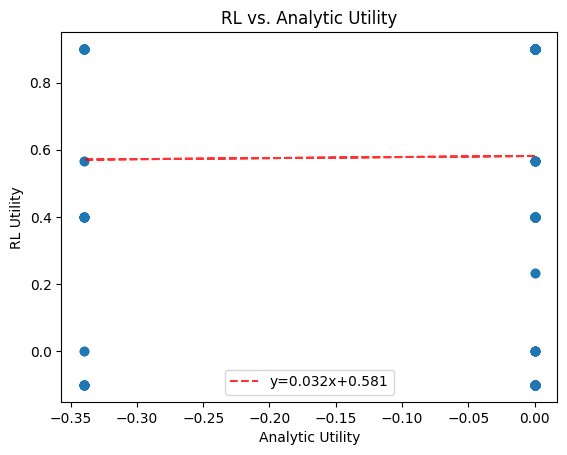

In [17]:
analytic_utility = [x[0] for x in analytic_rl_pairs]

rl_utility = [x[1] for x in analytic_rl_pairs]
# Add line of best fit
z = np.polyfit(analytic_utility, rl_utility, 1)
p = np.poly1d(z)
plt.plot(analytic_utility, p(analytic_utility), "r--", alpha=0.8, label=f"y={z[0]:.3f}x+{z[1]:.3f}")
plt.legend()

plt.scatter(analytic_utility, rl_utility)
plt.xlabel("Analytic Utility")
plt.ylabel("RL Utility")
plt.title("RL vs. Analytic Utility")
plt.show()

In [ ]:
train_env.step(np.array([0]));

BrokenPipeError: [Errno 32] Broken pipe